# Cardiovascular Disease Risk Prediction

#### The dataset is from an ongoing cardiovascular study on residents of the town of Framingham, Massachusetts. The classification goal is to predict whether the patient has 10-year risk of future coronary heart disease (CHD).The dataset provides the patients’ information. It includes over 4,000 records and 15 attributes.

#### Variables : Each attribute is a potential risk factor. There are both demographic, behavioral and medical risk factors.

## Loading Data and Importing Modules

In [117]:
# Importing the required libraries
import opendatasets as od
import os

import pandas as pd #To work with dataset
from sklearn.impute import SimpleImputer # to fill missing value
import numpy as np #Math library
import seaborn as sns #Graph library that use matplot in background
import plotly.express as px #For Visulization
import matplotlib.pyplot as plt #to plot some parameters in seaborn
from sklearn.preprocessing import LabelEncoder # to change categorical value to numerical values
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, classification_report, roc_curve
from imblearn.over_sampling import SMOTE # to handle inbalance data

import warnings
warnings.filterwarnings('ignore')

In [118]:
dataset = "https://www.kaggle.com/datasets/christofel04/cardiovascular-study-dataset-predict-heart-disea?select=train.csv"
data = od.download(dataset)

Skipping, found downloaded files in ".\cardiovascular-study-dataset-predict-heart-disea" (use force=True to force download)


In [119]:
data_dir = ".\cardiovascular-study-dataset-predict-heart-disea"

In [120]:
os.listdir(data_dir)

['.ipynb_checkpoints', 'test.csv']

#### Reading the cardiovascular study dataset datset using pandas

In [121]:
df = pd.read_csv('train.csv')

## Information About The Data

In [122]:
# Display first 5 indexes of the dataset 
df.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [123]:
#shape of given dataframe 
df.shape

(3390, 17)

In [124]:
# Information about the dataset and its columns data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

#### Checking for Missing And Duplicate values

In [125]:
df.isnull().sum()  

id                   0
age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

In [126]:
# Missing data counts and percentage

def missing_value():
    missing = df.columns[df.isnull().any()].tolist()
    return missing

print ('Missing Data Percentage')

print (round(df[missing_value()].isnull().sum().sort_values(ascending = False)*100/len(df),2))

Missing Data Percentage
glucose       8.97
education     2.57
BPMeds        1.30
totChol       1.12
cigsPerDay    0.65
BMI           0.41
heartRate     0.03
dtype: float64


In [127]:
df.duplicated().any()

False

In [128]:
df.drop(columns=['id'], inplace=True)

#### Handling Missing Values

In [129]:
# Descriptive Analysis of dataset
data_desc = df.describe().round(2)
data_desc

,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3390.00,3303.00,3368.00,3346.00,3390.00,3390.00,3390.00,3352.00,3390.00,3390.00,3376.00,3389.00,3086.00,3390.00
mean,49.54,1.97,9.07,0.03,0.01,0.32,0.03,237.07,132.60,82.88,25.79,75.98,82.09,0.15
std,8.59,1.02,11.88,0.17,0.08,0.46,0.16,45.25,22.29,12.02,4.12,11.97,24.24,0.36
min,32.00,1.00,0.00,0.00,0.00,0.00,0.00,107.00,83.50,48.00,15.96,45.00,40.00,0.00
25%,42.00,1.00,0.00,0.00,0.00,0.00,0.00,206.00,117.00,74.50,23.02,68.00,71.00,0.00
50%,49.00,2.00,0.00,0.00,0.00,0.00,0.00,234.00,128.50,82.00,25.38,75.00,78.00,0.00
75%,56.00,3.00,20.00,0.00,0.00,1.00,0.00,264.00,144.00,90.00,28.04,83.00,87.00,0.00
max,70.00,4.00,70.00,1.00,1.00,1.00,1.00,696.00,295.00,142.50,56.80,143.00,394.00,1.00


##### education, BPMeds fill missing value

In [130]:
df['education'].value_counts()

1.0    1391
2.0     990
3.0     549
4.0     373
Name: education, dtype: int64

In [131]:
df['BPMeds'].value_counts()

0.0    3246
1.0     100
Name: BPMeds, dtype: int64

Education and BPMeds feature is not a continues variable so we using Mode for filling the missing values.

In [132]:
df['education'].fillna(0, inplace=True)
df['BPMeds'].fillna(0, inplace=True)

##### Cigrates per Day, glucose, totChol, cigsPerDay, BMI, heartRate

In [133]:
X_mean_median= df[['cigsPerDay','glucose','totChol','BMI','heartRate']]

for col in X_mean_median:
    mean = df[col].mean().round(2)
    median = df[col].median()
    print(f"{col}:\n mean = {mean}\n median = {median} \n")

cigsPerDay:
 mean = 9.07
 median = 0.0 

glucose:
 mean = 82.09
 median = 78.0 

totChol:
 mean = 237.07
 median = 234.0 

BMI:
 mean = 25.79
 median = 25.38 

heartRate:
 mean = 75.98
 median = 75.0 



from the above we can see mean and median values are nearby for 'Cigrates per Day', 'glucose', 'totChol', 'cigsPerDay', 'BMI', 'heartRate'. so I'll use meadian value for filling the missing values.

In [134]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')

df[['cigsPerDay','glucose','totChol','BMI','heartRate']]= imp.fit_transform(df[['cigsPerDay','glucose','totChol','BMI','heartRate']])
                                                                            


In [135]:
df.isnull().sum().any()

False

So now there is no any null values in any columns.

# Exploratory Data Analysis (EDA)

The original dataset is ordinally encoded.

So while creating visualization for the interpretation purposes, I created a new dataframe in which ordinal numbers were replaced with corresponding categorical values.

In [136]:
df_viz = df.copy(deep = True)

df_viz['TenYearCHD'].replace({0: 'No', 1: 'Yes'}, inplace = True)
df_viz['sex'].replace({'F': 'woman', 'M': 'man'}, inplace = True)
df_viz['BPMeds'].replace({0: 'No', 1: 'Yes'}, inplace = True)
df_viz['prevalentHyp'].replace({0: 'No', 1: 'Yes'}, inplace = True)
df_viz['prevalentStroke'].replace({0: 'No', 1: 'Yes'}, inplace = True)
df_viz['diabetes'].replace({0: 'No', 1: 'Yes'}, inplace = True)

If your Total Cholesterol Level is:
* Less than 200mg/dL - Normal
* 200-239 mg/dL - Borderline high
* 240mg/dL and above - High
[reference](https://medlineplus.gov/lab-tests/cholesterol-levels/)


In [137]:
df_viz.loc[(df_viz.totChol < 200), 'totChol'] = 1
df_viz.loc[(df_viz.totChol >= 200) & (df_viz.totChol<= 239), 'totChol'] = 2
df_viz.loc[(df_viz.totChol >= 240), 'totChol'] = 3

df_viz['totChol'].replace({1: 'normal', 2: 'Borderline high', 3: 'Highl'}, inplace = True)

If your glucose Level is:  

* Less than 140mg/dL - Normal 
* 140-180 mg/dL - Borderline high 
* 180 mg/dL and above - High

In [138]:
df_viz.loc[(df_viz.glucose < 140), 'glucose'] = 1
df_viz.loc[(df_viz.glucose >= 140) & (df_viz.glucose<= 180), 'glucose'] = 2
df_viz.loc[(df_viz.glucose >= 180), 'glucose'] = 3

df_viz['glucose'].replace({1: 'normal', 2: 'Borderline high', 3: 'Highl'}, inplace = True)

If your BMI is:

* below 18.5 – you're in the underweight range
* between 18.5 and 24.9 – you're in the healthy weight range
* between 25 and 29.9 – you're in the overweight range
* between 30 and 39.9 – you're in the obese range[Reference](https://www.nhs.uk/common-health-questions/lifestyle/what-is-the-body-mass-index-bmi/)

In [139]:
df_viz.loc[(df_viz.BMI < 18.5), 'BMI'] = 1
df_viz.loc[(df_viz.BMI >= 18.5) & (df_viz.BMI<= 24.9), 'BMI'] = 2
df_viz.loc[(df_viz.BMI > 24.9) & (df_viz.BMI<= 29.9), 'BMI'] = 3
df_viz.loc[(df_viz.BMI > 29.9), 'BMI'] = 4

df_viz['BMI'].replace({1: 'underweight', 2: 'healthy', 3: 'overweight', 4: 'obesity'}, inplace = True)

## Numeric Columns

In [140]:
# Separating numeric and categorical columns
numeric_col = df_viz.select_dtypes(include = np.number).columns.tolist()
print("Numerical Columns:", numeric_col)

categorical_cols = df_viz.select_dtypes(include = 'object').columns.tolist()
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['age', 'education', 'cigsPerDay', 'sysBP', 'diaBP', 'heartRate']
Categorical Columns: ['sex', 'is_smoking', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'BMI', 'glucose', 'TenYearCHD']


#### sysBP, diaBP

Systolic pressure(sysBP) below 90 mmHg is considered low and may require intervention and management from your healthcare provider. If you get multiple systolic pressure readings above 190 mmHg, it is considered dangerously high and should be addressed by your healthcare provider. 

Normal diastolic blood(diaBP) pressure during quiet rest is below 80 mmHg. Diastolic blood pressure is considered dangerously low when it is 60 mmHg or lower and dangerously high when it is 110 mmHg or over. [reference](https://www.bloodpressureuk.org/your-blood-pressure/understanding-your-blood-pressure/what-do-the-numbers-mean/) 

With that information above, we may need to drop the data whose sysBP are <70 and >200. And for diaBP we need to drop those <40 and >130

In [141]:
df_viz.drop(df_viz[(df_viz.sysBP < 70) | (df_viz.sysBP > 200)].index, inplace = True)
df_viz.drop(df_viz[(df_viz.diaBP < 40) | (df_viz.diaBP > 130)].index, inplace = True)

Text(0.5, 1.0, 'Correlation Between sysBP and diaBP')

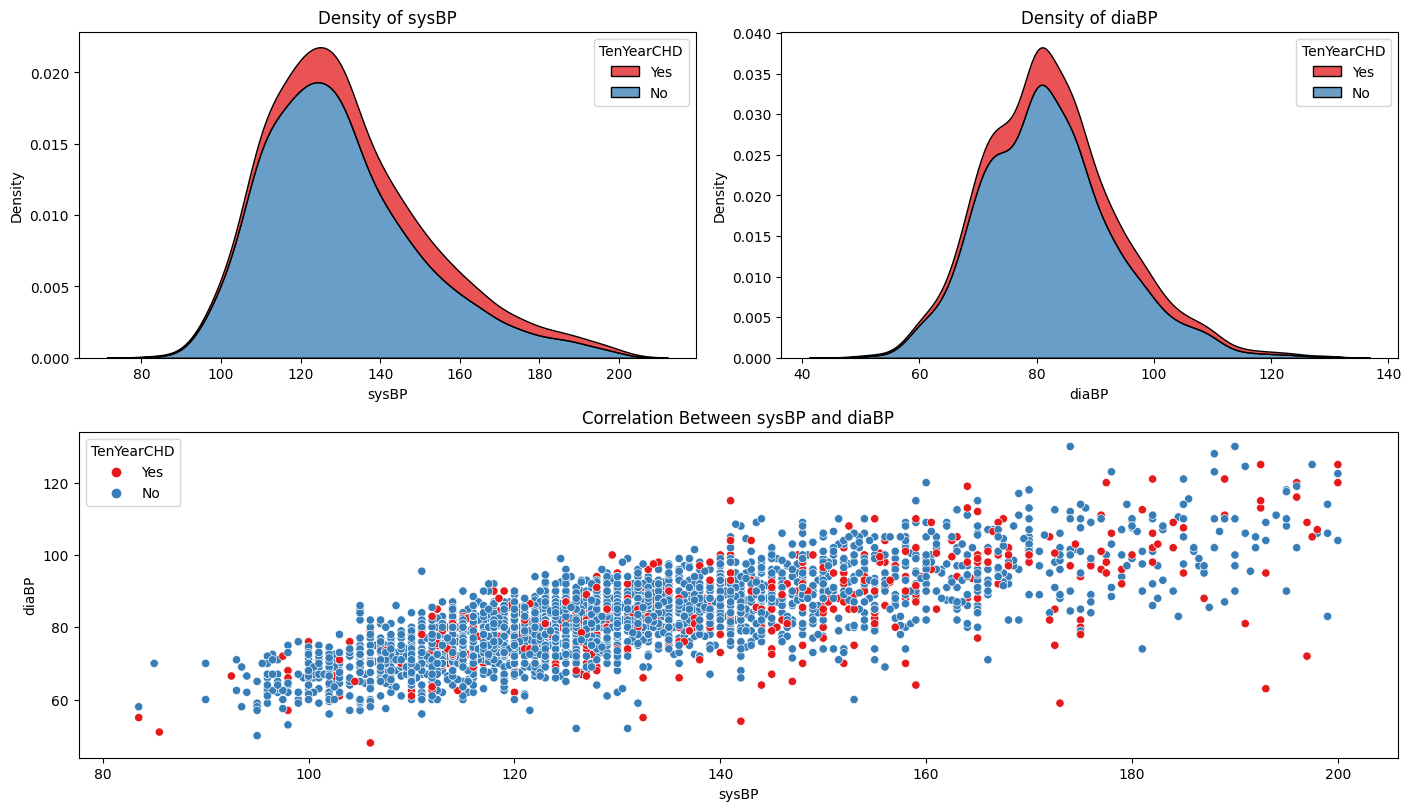

In [142]:
# Visualizing sysBP and diaBP

fig = plt.figure(figsize = (14, 8), constrained_layout = True)
gs = fig.add_gridspec(2, 4)
palette = {'No': '#377EB8', 'Yes': '#E41A1C'}

#sysBP Density
ax1 = fig.add_subplot(gs[0, :2])
ax1 = sns.kdeplot(data = df_viz, x = 'sysBP', hue = 'TenYearCHD',palette=palette, multiple = 'stack')
ax1.set_title('Density of sysBP')

#diaBP Density
ax2 = fig.add_subplot(gs[0, 2:])
ax2=sns.kdeplot(data = df_viz, x = 'diaBP', hue = 'TenYearCHD',palette=palette, multiple = 'stack')
ax2.set_title('Density of diaBP')

# correlation between sysBP and diaBP
ax3 = fig.add_subplot(gs[1, :])
ax3 = sns.scatterplot(data = df_viz, x = 'sysBP', y = 'diaBP', hue = 'TenYearCHD', palette = palette)
ax3.set_title('Correlation Between sysBP and diaBP')


From the above plots we can see that as Systolic pressure(sysBP) value increses more than 110 and Normal diastolic blood(diaBP) value increses more than 70, the cardiovascular disease  increses.

Also, the plot clearly indicates that there is a linear correlation between sysBP and diaBP.

In [143]:
df_viz['sysBP'].corr(df_viz['diaBP']).round(2)

0.77

The correlation coefficient between sysBP and diaBP is 0.77. We can also find the probability of getting cardiovascular disease when you meet these two conditions.

In [144]:
mean_sysBP = df_viz['sysBP'].mean()
mean_diaBP = df_viz['diaBP'].mean()

TenYearCHD_count = df_viz[(df_viz['sysBP'] > mean_sysBP) & (df_viz['diaBP'] > mean_diaBP)].TenYearCHD.value_counts()
TenYearCHD_count / TenYearCHD_count.sum()

No     0.792185
Yes    0.207815
Name: TenYearCHD, dtype: float64

### Cigsperday, Age, Heartrate

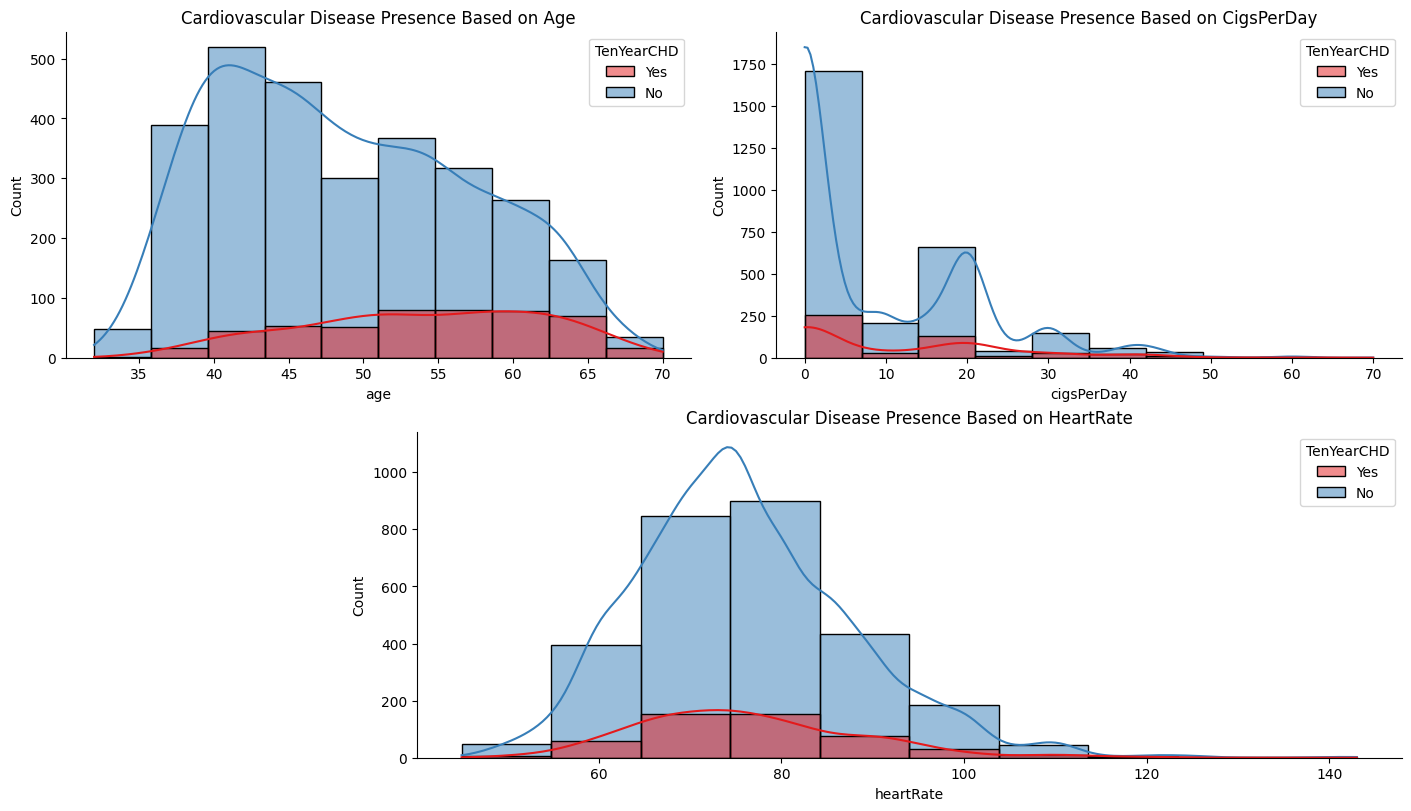

In [145]:
# Visualizing Cardiovascular Disease Presence Based on Age, cigsPerDay, heartRate
fig = plt.figure(figsize = (14, 8), constrained_layout = True)
gs = fig.add_gridspec(2, 4)
palette = {'No': '#377EB8', 'Yes': '#E41A1C'}

ax1 = fig.add_subplot(gs[0, :2])
ax1 = sns.histplot(data=df_viz,x="age",hue='TenYearCHD', bins=10,kde=True, palette=palette)
ax1.set_title('Cardiovascular Disease Presence Based on Age')

ax2 = fig.add_subplot(gs[0, 2:])
ax2 = sns.histplot(data=df_viz,x="cigsPerDay",hue='TenYearCHD', bins=10,kde=True, palette=palette)
ax2.set_title('Cardiovascular Disease Presence Based on CigsPerDay')

ax3 = fig.add_subplot(gs[1, 1:])
ax3 = sns.histplot(data=df_viz,x="heartRate",hue='TenYearCHD', bins=10,kde=True, palette=palette)
ax3.set_title('Cardiovascular Disease Presence Based on HeartRate')

sns.despine();

from the above plot it can be observed that people over 45 of age are more exposed to cardiovascular disease. so we can conclude that the chance of getting cardiovascular disease becomes larger as you get older.

In [146]:
mean_age = df_viz['age'].mean().round(0).astype(int)
CHD_count_age = df_viz[(df_viz['age'] > mean_age) | (df_viz['age'] == mean_age)].TenYearCHD.value_counts()
    
mean_heartRate = df_viz['heartRate'].mean()
CHD_count_heartRate = df_viz[(df_viz['heartRate'] > mean_heartRate)|(df_viz['heartRate']== mean_heartRate)].TenYearCHD.value_counts()    
    
print('\nIf your age is', mean_age, 'or above', mean_age)
print(CHD_count_age / CHD_count_age.sum())

print('\nIf your heartrate is', mean_heartRate, 'or above', mean_heartRate)
print(CHD_count_heartRate / CHD_count_heartRate.sum())


If your age is 49 or above 49
No     0.78804
Yes    0.21196
Name: TenYearCHD, dtype: float64

If your heartrate is 75.90461997019374 or above 75.90461997019374
No     0.849645
Yes    0.150355
Name: TenYearCHD, dtype: float64


### Categorical Columns

Categorical Columns: ['sex', 'is_smoking', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'BMI', 'glucose', 'TenYearCHD']

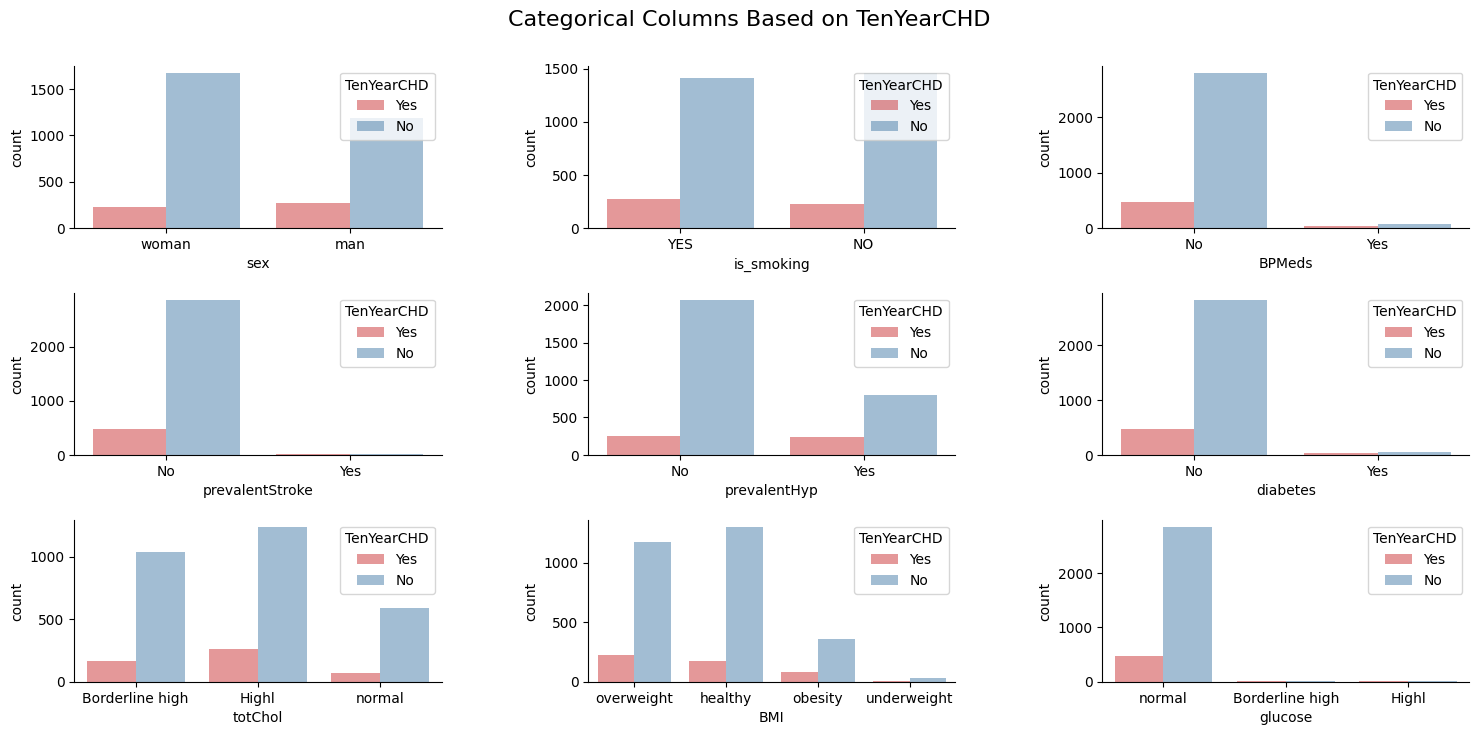

In [147]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (18, 8))

fig.suptitle('Categorical Columns Based on TenYearCHD', y = 0.95, fontsize = 16)
plt.subplots_adjust(hspace = 0.4, wspace = 0.4)

for pos, name in enumerate(categorical_cols[:-1]):
    sns.countplot(data = df_viz, x = name, hue = 'TenYearCHD', ax = axes.flat[pos], palette = palette, alpha = 0.5);

sns.despine()

In [148]:
print("Cardiovascular Disease Presence in Men and Women :")
print(round(df_viz.groupby('sex')['TenYearCHD'].value_counts() / df_viz.groupby('sex')['TenYearCHD'].count() * 100, 2))
print("--------------------------------------------------------------------------\n")

print("Cardiovascular Disease Presence in person who smokes :")
print(round(df_viz.groupby('is_smoking')['TenYearCHD'].value_counts() / df_viz.groupby('is_smoking')['TenYearCHD'].count() * 100, 2))
print("--------------------------------------------------------------------------\n")

print("Cardiovascular Disease Presence in who was on blood pressure medication or not(BPMeds) :")
print(round(df_viz.groupby('BPMeds')['TenYearCHD'].value_counts() / df_viz.groupby('BPMeds')['TenYearCHD'].count() * 100, 2))
print("--------------------------------------------------------------------------\n")

print("Cardiovascular Disease Presence in patient who was hypertensive or not:")
print(round(df_viz.groupby('prevalentHyp')['TenYearCHD'].value_counts() / df_viz.groupby('prevalentHyp')['TenYearCHD'].count() * 100, 2))
print("--------------------------------------------------------------------------\n")

print("Cardiovascular Disease Presence in patient who has diabetes:")
print(round(df_viz.groupby('diabetes')['TenYearCHD'].value_counts() / df_viz.groupby('diabetes')['TenYearCHD'].count() * 100, 2))
print("--------------------------------------------------------------------------\n")

print("Cardiovascular Disease Presence in who has total cholesterol level :")
print(round(df_viz.groupby('totChol')['TenYearCHD'].value_counts() / df_viz.groupby('totChol')['TenYearCHD'].count() * 100, 2))
print("--------------------------------------------------------------------------\n")

print("Cardiovascular Disease Presence who has BMI level :")
print(round(df_viz.groupby('BMI')['TenYearCHD'].value_counts() / df_viz.groupby('BMI')['TenYearCHD'].count() * 100, 2))
print("--------------------------------------------------------------------------\n")

print("Cardiovascular Disease Presence who has glucose level :")
print(round(df_viz.groupby('glucose')['TenYearCHD'].value_counts() / df_viz.groupby('glucose')['TenYearCHD'].count() * 100, 2))

Cardiovascular Disease Presence in Men and Women :
sex    TenYearCHD
man    No            81.76
       Yes           18.24
woman  No            88.14
       Yes           11.86
Name: TenYearCHD, dtype: float64
--------------------------------------------------------------------------

Cardiovascular Disease Presence in person who smokes :
is_smoking  TenYearCHD
NO          No            86.76
            Yes           13.24
YES         No            83.97
            Yes           16.03
Name: TenYearCHD, dtype: float64
--------------------------------------------------------------------------

Cardiovascular Disease Presence in who was on blood pressure medication or not(BPMeds) :
BPMeds  TenYearCHD
No      No            85.75
        Yes           14.25
Yes     No            71.74
        Yes           28.26
Name: TenYearCHD, dtype: float64
--------------------------------------------------------------------------

Cardiovascular Disease Presence in patient who was hypertensive or not

# Data preparatoin, handling and feature creation.

### Defining Correlation

Text(0.5, 1, 'Correlation of Variables')

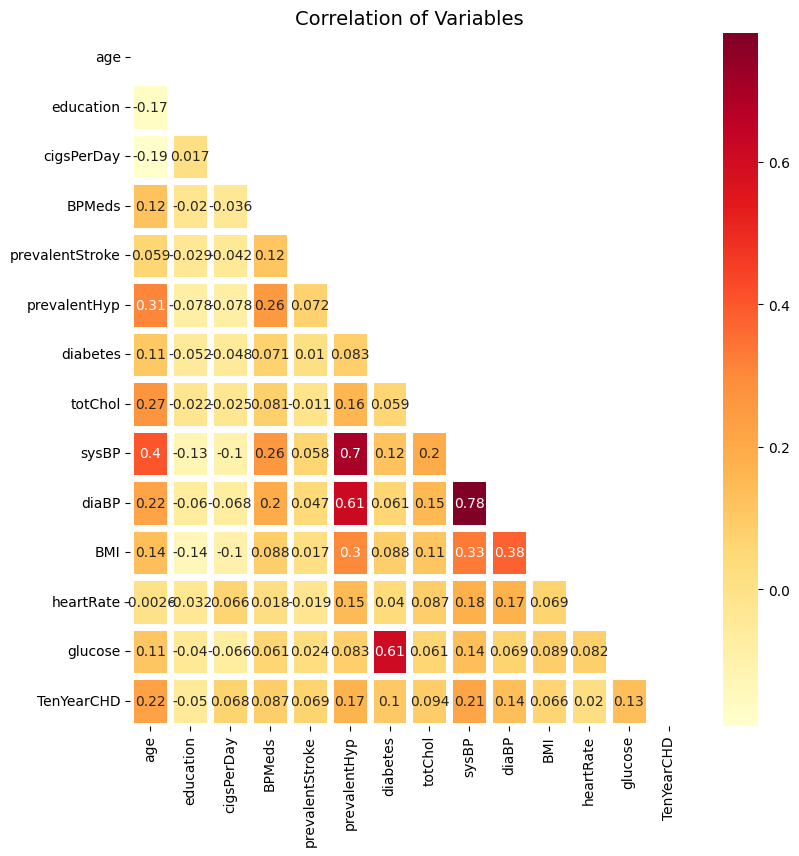

In [149]:
# Plotting heatmap to find correlation
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(9,9))
sns.heatmap(corr, ax=ax, mask=mask, annot=True,linewidths=5,cmap='YlOrRd')
plt.title("Correlation of Variables", y=1, size=14)

### Encoding of label

In [150]:
# categorical value's are cahnged to numerical values

labelEncoder= LabelEncoder()
df['sex'] = labelEncoder.fit_transform(df['sex'])
df['is_smoking'] = labelEncoder.fit_transform(df['is_smoking'])

### Sepration of dependent and independent variables and feature creation

In [151]:
# independent variable
X = df.drop(columns=['TenYearCHD'])

# dependent variable
y = df['TenYearCHD']

### Lets split the Data into train and test sets of data.

In [152]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Training dataset size:', X_train.shape)
print('Test dataset size:', X_test.shape)

Training dataset size: (2373, 15)
Test dataset size: (1017, 15)


## Handling Data Imbalalance

In [153]:
round(y_train.value_counts(normalize=True),2)

0    0.85
1    0.15
Name: TenYearCHD, dtype: float64

<AxesSubplot: xlabel='TenYearCHD', ylabel='count'>

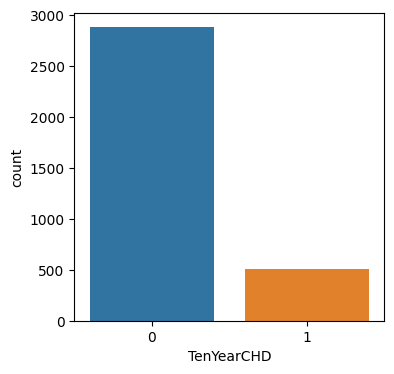

In [154]:
plt.figure(figsize=(4,4))
sns.countplot(x='TenYearCHD', data= df)

### It has been observed that our target class has an imbalance. So, we’ll try to upsample the data so that the minority class matches with the majority class by using  Minority Oversampling Technique or SMOTE .

In [155]:
sm = SMOTE(sampling_strategy='minority', random_state=42)
X_sm, y_sm = sm.fit_resample(X, y)

In [156]:
y_sm.value_counts()

1    2879
0    2879
Name: TenYearCHD, dtype: int64

Now our data is balanced. So we will use this X_sm, y_sm to train and test split.

In [157]:
X_train, X_test, y_train, y_test = train_test_split( X_sm,y_sm , test_size = 0.3, random_state = 42) 

# Model Selection

The Problem can be identified as Binary Classification such as whether patient have 10 year risk of coronary heart disease CHD or not.

Our problem is a classification and regression problem. We want to identify relationship between output (risk of coronary heart disease) with other variables or features (Gender, totchol, sysBP, diaBP...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Classification and Regression, we can narrow down our choice of models to a few. These include:

* Logistic Regression
* Support Vector Machines 
* KNN or k-Nearest Neighbors
* Naive Bayes Classifier or Gaussian Naive Bayes
* Decision Tree Classifier

## 1. Logistic Regression

In [158]:
# Model of logistic regression
model = LogisticRegression()
model = model.fit(X_train,y_train)
pred = model.predict(X_test)
lr_probability = model.predict_proba(X_test)[:,1]


accu_logReg = accuracy_score(y_test,pred)
recall_logReg = recall_score(y_test,pred)
prec_logReg = precision_score(y_test,pred)
f1_logReg = f1_score(y_test,pred)
Auc_logReg = (round(roc_auc_score(pred,y_test),2))

# accuracy and Roc_Auc values of model
print("Test_Accuracy : ", (round(accuracy_score(y_test, pred),2)))
print("ROC_AUC Score:",Auc_logReg)

Test_Accuracy :  0.64
ROC_AUC Score: 0.64


In [159]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       0.60      0.67      0.63       798
           1       0.68      0.62      0.65       930

    accuracy                           0.64      1728
   macro avg       0.64      0.64      0.64      1728
weighted avg       0.64      0.64      0.64      1728



### ROC Curve (receiver operating characteristic curve)

Text(0, 0.5, 'TPR (Recall)')

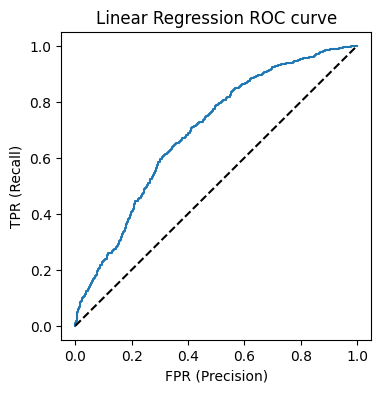

In [160]:
# The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings.
# FPR, on the other hand, defines how many incorrect positive results occur among all negative samples available during the test.
# TPR defines how many correct positive results occur among all positive samples available during the test.

fpr, tpr,_ = roc_curve(y_test, lr_probability)

plt.figure(figsize=(4,4))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'k--')
plt.title('Linear Regression ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)') 

[[531 355]
 [267 575]]


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

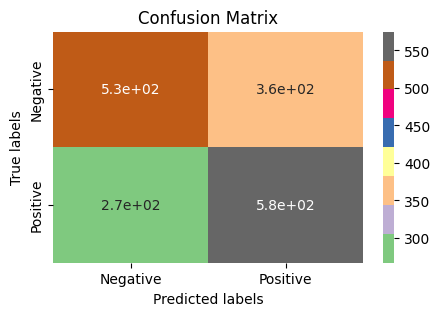

In [161]:
# Confusion matrix Linear Regression
plt.figure(figsize=(5,3))
ax= plt.subplot()
labels = ['Negative', 'Positive']

cm=confusion_matrix(y_test,pred)
print(cm)
sns.heatmap(cm,annot=True, ax=ax, cmap='Accent')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

## 2. Decision Tree Classifier

In [162]:
# Model of Decision Tree Classifier
DC_model = DecisionTreeClassifier()
DC_model = DC_model.fit(X_train,y_train)
DC_pred = DC_model.predict(X_test)
DC_probability = DC_model.predict_proba(X_test)[:,1]


accu_Classifier = accuracy_score(y_test,DC_pred)
recall_Classifier = recall_score(y_test,DC_pred)
prec_Classifier = precision_score(y_test,DC_pred)
f1_Classifier = f1_score(y_test,DC_pred)
Auc_Classifier = (round(roc_auc_score(DC_pred,y_test),2))

# accuracy and Roc_Auc values of model
print("Test_Accuracy : ", round(accuracy_score(y_test, DC_pred),2))
print("ROC_AUC Score:",Auc_Classifier)

Test_Accuracy :  0.81
ROC_AUC Score: 0.81


In [163]:
print(classification_report(DC_pred,y_test))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       841
           1       0.83      0.79      0.81       887

    accuracy                           0.81      1728
   macro avg       0.81      0.81      0.81      1728
weighted avg       0.81      0.81      0.81      1728



### ROC Curve of Decision Tree Classifier

Text(0, 0.5, 'TPR (Recall)')

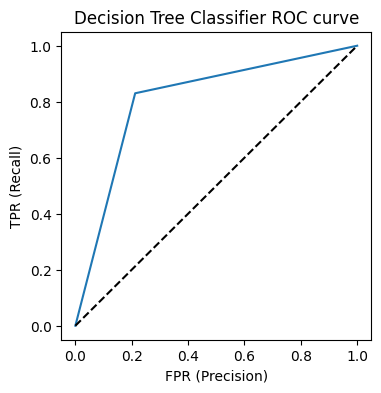

In [164]:
fpr, tpr,_ = roc_curve(y_test, DC_probability)

plt.figure(figsize=(4,4))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'k--')
plt.title('Decision Tree Classifier ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)') 

[[698 188]
 [143 699]]


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

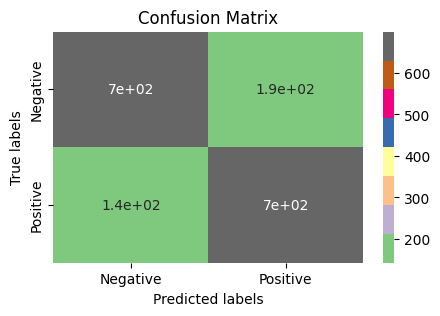

In [165]:
# Confusion matrix for Decision Tree Classifier
plt.figure(figsize=(5,3))
ax= plt.subplot()
labels = ['Negative', 'Positive']

cm=confusion_matrix(y_test,DC_pred)
print(cm)
sns.heatmap(cm,annot=True, ax=ax, cmap='Accent')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

## 3. SVM (Support Vector Machine)

In [166]:
# Model of SVM
SVM_model = SVC(probability=True)
SVM_model = SVM_model.fit(X_train,y_train)
SVM_pred = SVM_model.predict(X_test)
SVM_probability = SVM_model.predict_proba(X_test)[:,1]


accu_SVM = accuracy_score(y_test, SVM_pred)
recall_SVM = recall_score(y_test, SVM_pred)
prec_SVM = precision_score(y_test, SVM_pred)
f1_SVM = f1_score(y_test, SVM_pred)
Auc_SVM = (round(roc_auc_score(SVM_pred, y_test),2))

# accuracy and Roc_Auc values of model
print("Test_Accuracy : ", round(accuracy_score(y_test, SVM_pred),2))
print("ROC_AUC Score:",Auc_SVM)

Test_Accuracy :  0.68
ROC_AUC Score: 0.68


In [167]:
print(classification_report(SVM_pred, y_test))

              precision    recall  f1-score   support

           0       0.63      0.71      0.67       791
           1       0.72      0.65      0.68       937

    accuracy                           0.68      1728
   macro avg       0.68      0.68      0.68      1728
weighted avg       0.68      0.68      0.68      1728



### ROC Curve of SVM

Text(0, 0.5, 'TPR (Recall)')

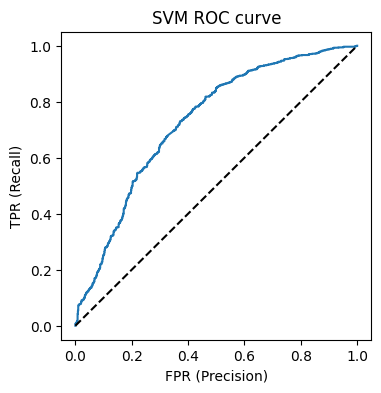

In [168]:
fpr, tpr, thresholds = roc_curve(y_test, SVM_probability)

plt.figure(figsize=(4,4))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'k--')
plt.title('SVM ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)') 

[[558 328]
 [233 609]]


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

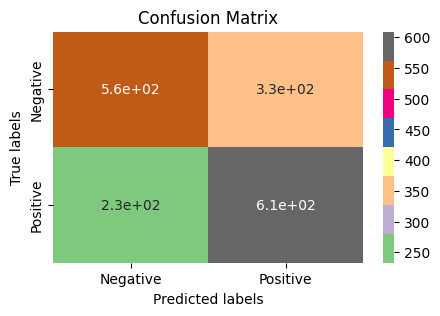

In [169]:
# Confusion matrix for SVM
plt.figure(figsize=(5,3))
ax= plt.subplot()
labels = ['Negative', 'Positive']

cm=confusion_matrix(y_test,SVM_pred)
print(cm)
sns.heatmap(cm,annot=True, ax=ax, cmap='Accent')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

## 4. Random Forest

In [170]:
RF_model = RandomForestClassifier() 
RF_grid_values = {'n_estimators':[50, 65, 80, 95,120], 'max_depth':[3, 5, 7,9,12]}
GSclassifier = GridSearchCV(RF_model, param_grid = RF_grid_values, scoring = 'roc_auc', cv=5)

# Fit the object to train dataset
GSclassifier.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9, 12],
                         'n_estimators': [50, 65, 80, 95, 120]},
             scoring='roc_auc')

In [171]:
#get best grid values
best_param = GSclassifier.best_params_
best_param

{'max_depth': 12, 'n_estimators': 95}

In [172]:
# Final Model of Decision Tree Classifier

RF_model = RandomForestClassifier(max_depth = best_param['max_depth'], n_estimators = best_param['n_estimators'])

RF_model = RF_model.fit(X_train, y_train)
RF_pred = RF_model.predict(X_test)
RF_probability = RF_model.predict_proba(X_test)[:,1]


accu_RF = accuracy_score(y_test, RF_pred)
recall_RF = recall_score(y_test, RF_pred)
prec_RF = precision_score(y_test,RF_pred)
f1_RF = f1_score(y_test, RF_pred)
Auc_RF = (round(roc_auc_score(RF_pred, y_test),2))

# accuracy and Roc_Auc values of model
print("Test_Accuracy : ", round(accuracy_score(y_test, RF_pred),2))
print("ROC_AUC Score:", Auc_RF)

Test_Accuracy :  0.88
ROC_AUC Score: 0.88


In [173]:
print(classification_report(RF_pred, y_test))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       884
           1       0.88      0.88      0.88       844

    accuracy                           0.88      1728
   macro avg       0.88      0.88      0.88      1728
weighted avg       0.88      0.88      0.88      1728



### ROC Curve of Random Forest Classifier

Text(0, 0.5, 'TPR (Recall)')

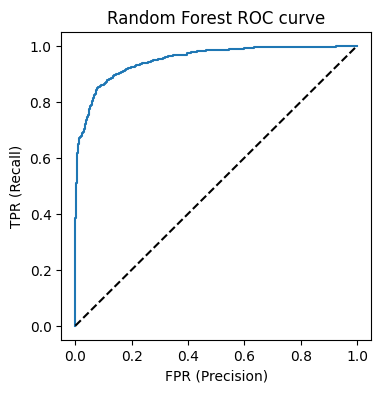

In [174]:
fpr, tpr, thresholds = roc_curve(y_test, RF_probability)

plt.figure(figsize=(4,4))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'k--')
plt.title('Random Forest ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)') 

[[782 104]
 [102 740]]


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

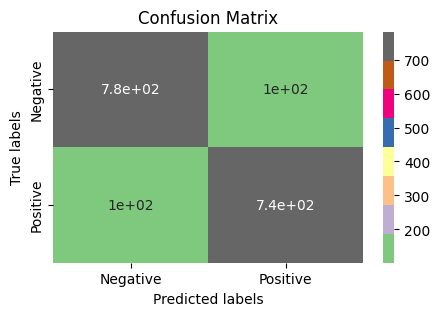

In [175]:
# Confusion matrix for Random Forest Classifier
plt.figure(figsize=(5,3))
ax= plt.subplot()
labels = ['Negative', 'Positive']

cm=confusion_matrix(y_test, RF_pred)
print(cm)
sns.heatmap(cm, annot=True, ax=ax, cmap='Accent')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [176]:
features = X.columns
importances = RF_model.feature_importances_
indices = np.argsort(importances)

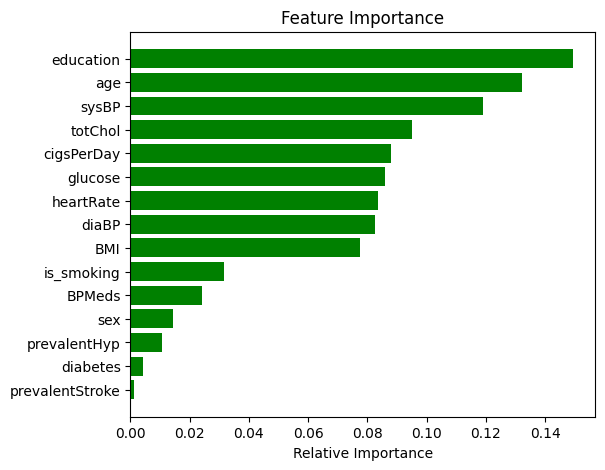

In [177]:
plt.figure(figsize=(6,5))
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='green', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## 5. KNN (K-Nearest Neighbors)

In [178]:
param_grid = {'n_neighbors':np.arange(1,30)}

KNN_model = KNeighborsClassifier()
KNN_cv= GridSearchCV(KNN_model, param_grid, cv=5)
KNN_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})

In [179]:
best_Params = KNN_cv.best_params_
best_Params

{'n_neighbors': 2}

In [180]:
# Final Model of KNN

KNN_model = KNeighborsClassifier(n_neighbors = best_Params['n_neighbors'])

KNN_model = KNN_model.fit(X_train, y_train)
KNN_pred = KNN_model.predict(X_test)
KNN_probability = KNN_model.predict_proba(X_test)[:,1]


accu_KNN = accuracy_score(y_test, KNN_pred)
recall_KNN = recall_score(y_test, KNN_pred)
prec_KNN = precision_score(y_test,KNN_pred)
f1_KNN = f1_score(y_test, KNN_pred)
Auc_KNN = (round(roc_auc_score(KNN_pred, y_test),2))

# accuracy and Roc_Auc values of model
print("Test_Accuracy : ", round(accuracy_score(y_test, KNN_pred),2))
print("ROC_AUC Score:", Auc_KNN)

Test_Accuracy :  0.87
ROC_AUC Score: 0.87


In [181]:
print(classification_report(KNN_pred, y_test))

              precision    recall  f1-score   support

           0       0.82      0.91      0.87       796
           1       0.92      0.83      0.87       932

    accuracy                           0.87      1728
   macro avg       0.87      0.87      0.87      1728
weighted avg       0.87      0.87      0.87      1728



### KNN ROC Curve

Text(0, 0.5, 'TPR (Recall)')

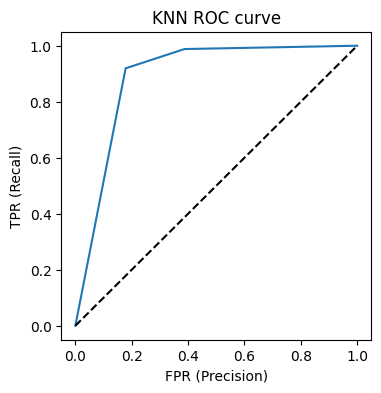

In [182]:
fpr, tpr, thresholds = roc_curve(y_test, KNN_probability)

plt.figure(figsize=(4,4))
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],'k--')
plt.title('KNN ROC curve')
plt.xlabel('FPR (Precision)')
plt.ylabel('TPR (Recall)') 

[[728 158]
 [ 68 774]]


[Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')]

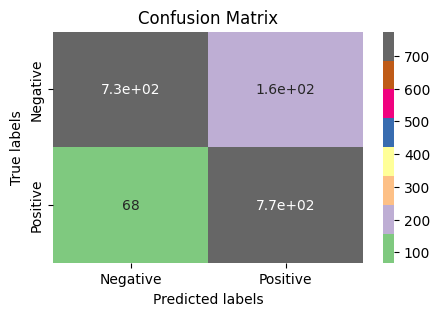

In [183]:
# Confusion matrix for KNN
plt.figure(figsize=(5,3))
ax= plt.subplot()
labels = ['Negative', 'Positive']

cm=confusion_matrix(y_test, KNN_pred)
print(cm)
sns.heatmap(cm, annot=True, ax=ax, cmap='Accent')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

## Comparison of the different models

In [184]:
## Comparing the performance of the models

ind=['Logistic regression','Decision Tree Classifier','Support Vector Machine(SVM)','Randomforest','KNN']

data={"Accuracy":[accu_logReg, accu_Classifier, accu_SVM, accu_RF, accu_KNN],
      "Recall":[recall_logReg, recall_Classifier, recall_SVM, recall_RF, recall_KNN],
      "Precision":[prec_logReg, prec_Classifier,prec_SVM, prec_RF, prec_KNN],
      'f1_score':[f1_logReg, f1_Classifier, f1_SVM, f1_RF, f1_KNN],
      "ROC_AUC":[Auc_logReg, Auc_Classifier, Auc_SVM, Auc_RF, Auc_KNN]}

result=pd.DataFrame(data=data,index=ind)
result


,Accuracy,Recall,Precision,f1_score,ROC_AUC
Logistic regression,0.640046,0.682898,0.618280,0.648984,0.64
Decision Tree Classifier,0.808449,0.830166,0.788050,0.808560,0.81
Support Vector Machine(SVM),0.675347,0.723278,0.649947,0.684654,0.68
Randomforest,0.880787,0.878860,0.876777,0.877817,0.88
KNN,0.869213,0.919240,0.830472,0.872604,0.87


# Conclusion

* People over 45 of age are more exposed to cardiovascular disease.


*  Systolic pressure(sysBP) value increses more than 110 and Normal diastolic blood(diaBP) value increses more than 70, the the risk of cardiovascular disease increse.


* Man have higher risk of CHD than the Woman. Also the person who smokes, who was on blood pressure medication, who was hypertensive, who has diabetes, who has obesity or overweight, who has high cholesterol, and who has high glucose level have higher chance of getting cardiovascular disease.


* The variable such as totcol, age, Cigsperday, is_smoking, sysBP, diaBP, glucose is more affecting the target variable.


* From all above the five ML model Random forest and KNN performs better. Beacuse both model have higher accuracy and f1_score. Also both the model's ROC curves closer to the top-left corner which indicates better performance. 